In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import gzip
import re
import matplotlib.pyplot as plt


P=0.05

In [2]:
cll_data=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/cll_data.20230116.csv")

groups_file_path='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.shuffle/groups_file.shuffle.20230116/'

In [3]:
# covariates table for DS 
covariate_table=pd.read_csv("/home/ls/rachelcw/projects/PEER/covariates_table_20230109.csv", index_col=0)

# convert binary data to labels #
# # F - M
covariate_table['F']=covariate_table['F'].replace([1,0],['F','M'])
covariate_table.drop(columns='M', inplace=True)
covariate_table.rename(columns={'F':'F/M'},inplace=True)
# # S-spain vs B-broad
covariate_table['seqcenter_Spain']=covariate_table['seqcenter_Spain'].replace([1,0],['S','B'])
covariate_table.drop(columns='seqcenter_Broad', inplace=True)
covariate_table.rename(columns={'seqcenter_Spain':'seqcenter'},inplace=True)
## LCSET
covariate_table['LCSET']=''
for col in covariate_table.filter(regex="^LCSET_").columns:
    covariate_table[col]=covariate_table[col].replace([1,0],[col,''])
    covariate_table['LCSET']= covariate_table['LCSET'] + covariate_table[col]

covariate_table=covariate_table.loc[:,~covariate_table.columns.str.startswith('LCSET_')]
covariate_table = covariate_table.mask(covariate_table=='')


In [4]:
def groups_file_gene(gene,output,shuffle=False,ighv=None):
    cll_data=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/cll_data.20230116.csv")
    if ighv in ['M-CLL','U-CLL']:
        print(ighv)
        cll_data=cll_data[cll_data['ighv_mut']==ighv]
    # Unmutated SF3B1
    data_unmut=cll_data[cll_data['SF3B1_mut']=='Unmutated SF3B1']
    #gene expression P low
    n=round(len(data_unmut)*P)
    low=np.array(data_unmut.nsmallest(n, columns=gene, keep='all')['key'])
    #gene expression P high
    high=np.array(data_unmut.nlargest(n, columns=gene, keep='all')['key'])
    samples=np.append(low,high)
    analysis=covariate_table.filter(items=samples, axis='index')
    groups_file=open(output,'w')
    if shuffle:
        labels=np.array(['low','high'])
        lables_list = np.repeat(labels,[len(low),len(high)],axis=0)
        labels_shuffle=np.random.permutation(lables_list)
        for label,sample in zip(labels_shuffle, samples):
            groups_file.writelines([sample,'\t'+label+'\t',analysis.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
    else:
        #  create a file that specifies which samples go in each group- low vs. high 
        for sample in low:
            groups_file.writelines([sample, '\tlow\t',analysis.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
        for sample in high:
            groups_file.writelines([sample, '\thigh\t',analysis.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
    groups_file.close()
    
    
    

In [7]:
def groups_file_sf3b1(output,shuffle=False,ighv=None):
    cll_data=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/cll_data.20230116.csv")
    if ighv in ['M-CLL','U-CLL']:
        print(ighv)
        cll_data=cll_data[cll_data['ighv_mut']==ighv]
    # Unmutated SF3B1
    unmut_sample=np.array(cll_data[cll_data['SF3B1_mut']=='Unmutated SF3B1']['key'])
    # mutated SF3B1
    mut_sample=np.array(cll_data[cll_data['SF3B1_mut']=='Mutated SF3B1']['key'])

    samples=np.append(unmut_sample,mut_sample)
    analysis=covariate_table.filter(items=samples, axis='index')

    #  create a file that specifies which samples go in each group- unmut vs. mut 
    groups_file=open(output,'w')
    if shuffle:
        labels=np.array(['\tunmut\t','\tmut\t'])
        lables_list = np.repeat(labels,[len(unmut_sample),len(mut_sample)],axis=0)
        labels_shuffle=np.random.permutation(lables_list)
        for label,sample in zip(labels_shuffle, samples):
            groups_file.writelines([sample,label,analysis.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
    else:
        for sample in unmut_sample:
            groups_file.writelines([sample, '\tunmut\t',analysis.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
        for sample in mut_sample:
            groups_file.writelines([sample, '\tmut\t',analysis.loc[sample].to_string(header=False,index=False).replace('\n','\t'),'\n'])
    groups_file.close()

In [ ]:
cll_data=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/cll_data.20230116.csv")

cll_data=cll_data[cll_data['ighv_mut']=='M-CLL']
# Unmutated SF3B1
unmut_sample=np.array(cll_data[cll_data['SF3B1_mut']=='Unmutated SF3B1']['key'])
# mutated SF3B1
mut_sample=np.array(cll_data[cll_data['SF3B1_mut']=='Mutated SF3B1']['key'])

samples=np.append(unmut_sample,mut_sample)
analysis=covariate_table.filter(items=samples, axis='index')


In [11]:
# # analysis #1 : ucll+mcll - u SF3B1 - low\high SUGP1 # #
output=groups_file_path+"groups_file_s1.txt"
groups_file_gene('SUGP1',output,shuffle=True)


In [12]:
# # analysis #2 : ucll+mcll - u SF3B1 - m SF3B1 # #
output=groups_file_path+"groups_file_s2.txt"
groups_file_sf3b1(output,shuffle=True)

In [13]:
# # analysis #7 : ucll+mcll - u SF3B1 - low\high DHX15 # #
output=groups_file_path+"groups_file_s7.txt"
groups_file_gene('DHX15',output,shuffle=True)

In [14]:
# # analysis #3 : mcll - u SF3B1 - low\high SUGP1 # #
output=groups_file_path+"groups_file_s3.txt"
groups_file_gene('SUGP1',output,ighv='M-CLL',shuffle=True)


M-CLL


In [15]:
# # analysis #4 : mcll - u SF3B1 - m SF3B1 # #
output=groups_file_path+"groups_file_s4.txt"
groups_file_sf3b1(output,ighv='M-CLL')

M-CLL


In [16]:
# # analysis #8 : mcll - u SF3B1 - low\high DHX15 # #
output=groups_file_path+"groups_file_s8.txt"
groups_file_gene('DHX15',output, shuffle=True,ighv='M-CLL')


M-CLL


In [17]:
# # analysis #5 : ucll - u SF3B1 - low\high SUGP1 # #
output=groups_file_path+"groups_file_s5.txt"
groups_file_gene('SUGP1',output, shuffle=True,ighv='U-CLL')

U-CLL


In [18]:
# # analysis #6 : ucll - u SF3B1 - m SF3B1 # #
output=groups_file_path+"groups_file_s6.txt"
groups_file_sf3b1(output,ighv='U-CLL',shuffle=True)


U-CLL


In [19]:
# # analysis #9 : ucll - u SF3B1 - low\high DHX15 # #
output=groups_file_path+"groups_file_s9.txt"
groups_file_gene('DHX15',output, shuffle=True,ighv='U-CLL')

U-CLL


In [18]:
#   #   RUN LEAFCUTTER DS   #   #
# docker run -v /home/ls/rachelcw/projects/LEAFCUTTER/:/data --rm garrettjenkinson/ubuntu18leafcutter:v0.2.9.1 Rscript /leafcutter/scripts/leafcutter_ds.R /data/lc_20230108/lc_20230108_perind_numers.counts.gz /data/DS/DS.five_percent/groups_file.analysis.20230108/groups_file_a2.txt -o /data/DS/DS.five_percent/ds.a2.20230108 -p 12
# docker run -v /home/ls/rachelcw/projects/LEAFCUTTER/:/data --rm garrettjenkinson/ubuntu18leafcutter:v0.2.9.1 Rscript /leafcutter/scripts/leafcutter_ds.R /data/lc_20221211/lc_20221211_perind_numers.counts.gz /data/DS/DS.five_percent/shuffle_groups_file/groups_file_s6.txt -o /data/DS/DS.five_percent/ds.s6.20221227 -p 6


In [ ]:
#   #   DS result anf filtering    #   #
FDR = 0.05

for i in ['9']:
    input_path='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.shuffle/shuffle.20230116/ds.s'+i+'.20230116'
    cluster_sig= pd.read_table(input_path+'_cluster_significance.txt',sep='\t')
    #filter out all clusters that they arnt sugnificant <=0.05

    cluster_sig=cluster_sig[cluster_sig['p.adjust'] <= FDR]
    clusters=list(cluster_sig['cluster'].str.split(':',expand=True)[0]+'.*'+cluster_sig['cluster'].str.split(':',expand=True)[1])

    effect_sizes=pd.read_table(input_path+'_effect_sizes.txt',sep='\t')

    #   #   #   #   #   #   #   #   #   #   #   #  

    filtered_intron=[]
    intron=list(effect_sizes['intron'])
    for x in clusters:
        for y in intron:
            r = re.compile(x)
            z=r.search(y)
            if z != None:
                filtered_intron.append(z.string)


    #   #   #   #   #   #   #   #   #   #   #   #              

    effect_sizes.set_index('intron', inplace=True)
    effect_sizes=effect_sizes.filter(items=filtered_intron,axis='index')

    #   #   #   #   #   #   #   #   #   #   #   #   
    output_path='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.shuffle/shuffle.20230116/filtered.s' + i + '.20230116'
    print(output_path)

    cluster_sig.to_csv(output_path+'_cluster_significance.txt', sep=' ',index=False)
    effect_sizes.to_csv(output_path+'_effect_sizes.txt', sep=' ')



In [3]:
percent_perind=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/lc_20230108/lc_20230108_perind.percent.csv")

In [4]:
for i in [2,4,6]:
    filtered_cll=pd.read_csv(f"/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a{i}.20230115_effect_sizes.txt", sep=' ')
    # junction from filter
    junction_cll=filtered_cll["intron"].str.replace("chr","")
    # column of m sf3b1 | um sf3b1
    # add percent reads of sample per junction
    filtered_percent=percent_perind.loc[percent_perind["chrom"].isin(junction_cll)]

    melt_filtered_percent=pd.melt(filtered_percent, id_vars=filtered_percent.columns[0], value_vars=filtered_percent.columns[1:],var_name="sample", value_name="reads_percent")
    melt_filtered_percent.rename(columns={"chrom":"junction"}, inplace=True)
    # group by m-um
    groups_file=pd.read_csv(f"/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/groups_file.analysis.20230108/groups_file_a{i}.txt", sep="\t", usecols=[0,1], header=None, names=["sample", "sf3b1"])

    merge_groups_percent=melt_filtered_percent.merge(groups_file,how="inner",on="sample")
    # mean and sd for each junction
    merge_groups_percent.groupby(["junction","sf3b1"]).agg(['mean','std']).to_csv(f"~/projects/LEAFCUTTER/mean_std_junction/analysis{i}_ms.csv")
   

/tmp/ipykernel_896487/1501759231.py:16: FutureWarning: ['sample'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  merge_groups_percent.groupby(["junction","sf3b1"]).agg(['mean','std']).to_csv(f"~/projects/LEAFCUTTER/mean_std_junction/analysis{i}_ms.csv")
/tmp/ipykernel_896487/1501759231.py:16: FutureWarning: ['sample'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  merge_groups_percent.groupby(["junction","sf3b1"]).agg(['mean','std']).to_csv(f"~/projects/LEAFCUTTER/mean_std_junction/analysis{i}_ms.csv")
/tmp/ipykernel_896487/1501759231.py:16: FutureWarning: ['sample'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  merge_groups_percent.groupby(["junction","sf3b1"]).agg(['mean','std'])

In [10]:
# save pivot as csv file
for i in [2]:
    data=pd.read_csv(f"~/projects/LEAFCUTTER/mean_std_junction/analysis{i}_ms.csv", names=["junction","sf3b1","mean","std"])
    data.drop(index=[0,1,2], inplace=True)
    data.pivot(index="junction",columns="sf3b1", values=["mean","std"]).to_csv(f"~/projects/LEAFCUTTER/mean_std_junction/analysis{i}_pivot.csv")
    data_pivot=pd.read_csv(f"~/projects/LEAFCUTTER/mean_std_junction/analysis{i}_pivot.csv", names=["junction","mean_mut","mean_unmut","std_mut","std_unmut"])
    data_pivot.drop(index=[0,1,2], inplace=True)
    data_pivot["mean_mut"]=[float(element) for element in data_pivot["mean_mut"]]
    data_pivot["mean_unmut"]=[float(element) for element in data_pivot["mean_unmut"]]
    data_pivot["deltapsi"]=data_pivot["mean_mut"]-data_pivot["mean_unmut"]
    data_pivot.to_csv(f"../LEAFCUTTER/mean_std_junction/deltapsi_analysis{i}.csv", index=False)
# scatter plot - deltapsi new vs lc

In [64]:
mcll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/mean_std_junction/mcll.csv")
ucll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/mean_std_junction/ucll.csv")
mucll=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/mean_std_junction/mucll.csv")

In [67]:
table=pd.merge(mcll,ucll,how="outer",on="junction", suffixes=["_mcll","_ucll"])
table.filter(items=["junction","deltapsi_mcll","deltapsi_ucll"])


,junction,deltapsi_mcll,deltapsi_ucll
0,10:100174949:100175306:clu_57066_NA,0.009219,0.009219
1,10:100174954:100175306:clu_57066_NA,-0.028443,-0.028443
2,10:100174954:100176817:clu_57066_NA,-0.037177,-0.037177
3,10:100175190:100175306:clu_57066_NA,0.090615,0.090615
4,10:100175513:100176817:clu_57066_NA,0.054917,0.054917
...,...,...,...
4969,Y:15023880:15024639:clu_31737_NA,-0.063391,-0.063391
4970,Y:21871464:21872262:clu_31786_NA,0.009184,0.009184
4971,Y:21871695:21872101:clu_31786_NA,0.002485,0.002485
4972,Y:21871695:21872262:clu_31786_NA,0.176581,0.176581


In [3]:
a1=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a1.20230115_cluster_significance.txt", sep=' ')
a2=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a2.20230115_cluster_significance.txt", sep=' ')
a3=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a3.20230115_cluster_significance.txt", sep=' ')
a4=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a4.20230115_cluster_significance.txt", sep=' ')
a6=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a6.20230115_cluster_significance.txt", sep=' ')
a7=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a7.20230115_cluster_significance.txt", sep=' ')
a8=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.05/filtered.a8.20230115_cluster_significance.txt", sep=' ')
s1=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.shuffle/shuffle.20230116/filtered.s1.20230116_cluster_significance.txt", sep=' ')
s2=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.shuffle/shuffle.20230116/filtered.s2.20230116_cluster_significance.txt", sep=' ')
s2=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.shuffle/shuffle.20230116/filtered.s2.20230116_cluster_significance.txt", sep=' ')
s3=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.shuffle/shuffle.20230116/filtered.s3.20230116_cluster_significance.txt", sep=' ')
s4=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.shuffle/shuffle.20230116/filtered.s4.20230116_cluster_significance.txt", sep=' ')
s6=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.shuffle/shuffle.20230116/filtered.s6.20230116_cluster_significance.txt", sep=' ')
s7=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.shuffle/shuffle.20230116/filtered.s7.20230116_cluster_significance.txt", sep=' ')
s8=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.shuffle/shuffle.20230116/filtered.s8.20230116_cluster_significance.txt", sep=' ')


[Text(0, 0, 'mucll-lh'),
 Text(1, 0, 'mucll-mu'),
 Text(2, 0, 'mucll-DHX15'),
 Text(3, 0, 'mcll-lh'),
 Text(4, 0, 'mcll-mu'),
 Text(5, 0, 'mcll-DHX15'),
 Text(6, 0, 'ucll-lh'),
 Text(7, 0, 'ucll-mu'),
 Text(8, 0, 'ucll-DHX15')]

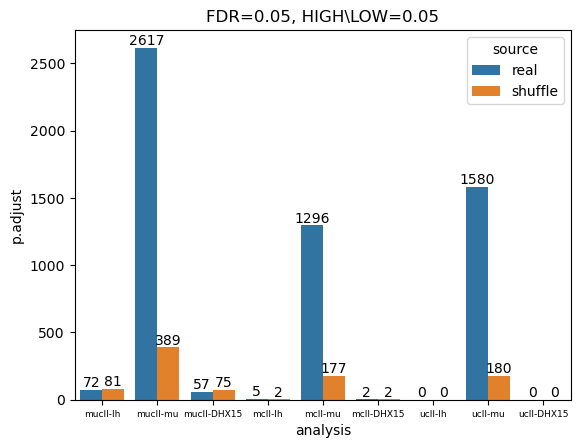

In [7]:
FDR=0.05
shuffle=pd.DataFrame({'analysis':['mucll-lh','mucll-mu','mucll-DHX15','mcll-lh','mcll-mu','mcll-DHX15','ucll-lh','ucll-mu','ucll-DHX15'],'p.adjust':[len(s1['p.adjust']),len(s2['p.adjust']),len(s7['p.adjust']),len(s3['p.adjust']),len(s4['p.adjust']),len(s8['p.adjust']),0,len(s6['p.adjust']),0],'source':'shuffle'})
real=pd.DataFrame({'analysis':['mucll-lh','mucll-mu','mucll-DHX15','mcll-lh','mcll-mu','mcll-DHX15','ucll-lh','ucll-mu','ucll-DHX15'],'p.adjust':[len(a1['p.adjust']),len(a2['p.adjust']),len(a7['p.adjust']),len(a3['p.adjust']),len(a4['p.adjust']),len(a8['p.adjust']),0,len(a6['p.adjust']),0],'source':'real'})
data_merge=pd.merge(left=real,right=shuffle,how='outer')
ax=sns.barplot(data_merge,x='analysis',y='p.adjust',hue='source')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
ax.set(title=f'FDR={FDR}, HIGH\LOW={P}')
ax.set_xticklabels(ax.get_xticklabels(),fontsize=6.5)


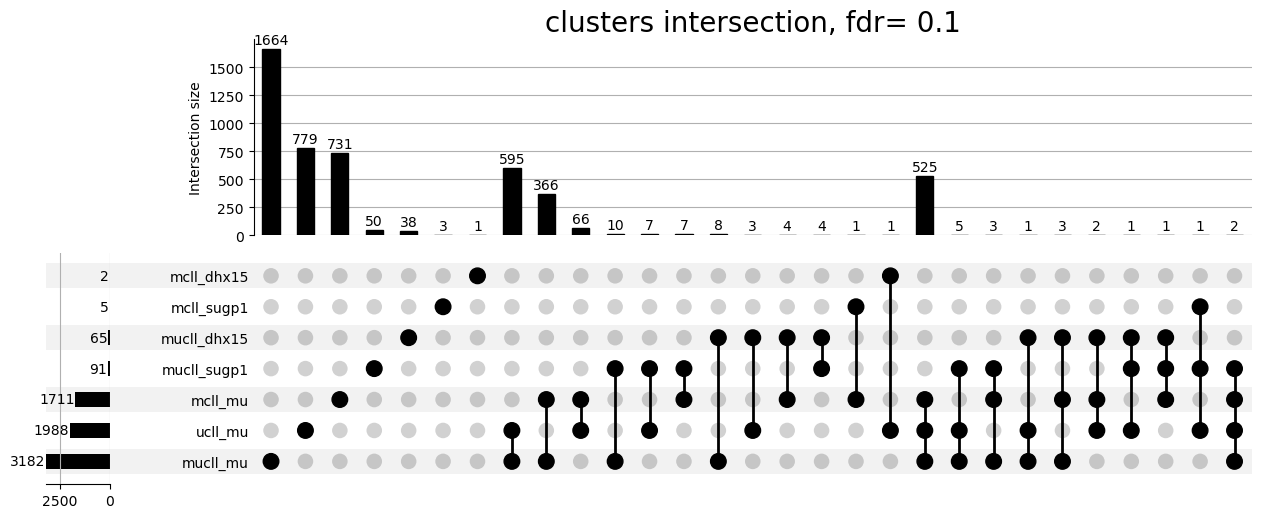

In [49]:
# # UpSet plot # #
import upsetplot as usp

mucll_sugp1=pd.read_csv('/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.1/filtered0.1.a1.20230115_cluster_significance.txt', sep=' ')
mucll_sugp1_cluster=list(mucll_sugp1.cluster)
mucll_mu=pd.read_csv('/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.1/filtered0.1.a2.20230115_cluster_significance.txt', sep=' ')
mucll_mu_cluster=list(mucll_mu.cluster)
mucll_dhx15=pd.read_csv('/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.1/filtered0.1.a7.20230115_cluster_significance.txt', sep=' ')
mucll_dhx15_cluster=list(mucll_dhx15.cluster)

mcll_sugp1=pd.read_csv('/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.1/filtered0.1.a3.20230115_cluster_significance.txt', sep=' ')
mcll_sugp1_cluster=list(mcll_sugp1.cluster)
mcll_mu=pd.read_csv('/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.1/filtered0.1.a4.20230115_cluster_significance.txt', sep=' ')
mcll_mu_cluster=list(mcll_mu.cluster)
mcll_dhx15=pd.read_csv('/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.1/filtered0.1.a8.20230115_cluster_significance.txt', sep=' ')
mcll_dhx15_cluster=list(mcll_dhx15.cluster)

ucll_mu=pd.read_csv('/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/analysis.20230115/fdr0.1/filtered0.1.a6.20230115_cluster_significance.txt', sep=' ')
ucll_mu_cluster=list(ucll_mu.cluster)

analysis=usp.from_contents({'mucll_sugp1':mucll_sugp1_cluster,'mucll_mu':mucll_mu_cluster,'mucll_dhx15':mucll_dhx15_cluster,'mcll_sugp1':mcll_sugp1_cluster,'mcll_mu':mcll_mu_cluster,'mcll_dhx15':mcll_dhx15_cluster,'ucll_mu':ucll_mu_cluster})
# analysis=usp.from_contents({'mucll_sugp1':mucll_sugp1_cluster,'mucll_mu':mucll_mu_cluster,'mucll_dhx15':mucll_dhx15_cluster})

upset=usp.UpSet(analysis,subset_size='count',show_counts=True)
# upset.style_subsets(present=["mucll_mu","mucll_dhx15"], facecolor="blue",label="mucll")
# upset.style_subsets(present=["mucll_mu","mucll_sugp1"], facecolor="cyan",label="mucll")
# upset.style_subsets(present=["mucll_sugp1","mcll_sugp1"], facecolor="red",label="sugp1")
upset.plot()
plt.title("clusters intersection, fdr= 0.1").set_fontsize(20)
plt.show()


In [3]:
#dictionary samples
table_sample=pd.read_csv("/private1/private/data/cllmap/metadata/all_deidentifier_patAndSamp_20220308.tsv",sep='\t')
# table_cllmap=pd.read_csv("/home/ls/rachelcw/projects/cllmap_pat_samp_id_map.extended.20221205.tsv",sep='\t')
# rna_id=list(table_cllmap['rna_tumor_sample_id'].dropna())
dict_sample=dict(zip(table_sample[table_sample.columns[0]],table_sample[table_sample.columns[1]]))

In [74]:
# # edit cll data - add dhx15 ex, rename columns, replace values # #

# master_table=pd.read_csv("/home/ls/rachelcw/projects/cllmap_rnaseq_tpms_603samps_deseqLog10_batchcorr.tsv",sep="\t")
# dhx15=master_table.loc[(master_table['Description']=='DHX15')]
# dhx15=dhx15.drop(columns=["Name"])
# dhx15.set_index('Description',inplace=True)
# dhx15_t=dhx15.T
# cll_data=cll_data.merge(dhx15_t,right_index=True,left_on='key')
# cll_data['ighv_mut'] = cll_data['ighv_mut'].replace(['unmutated', 'mutated'], ['U-CLL', 'M-CLL'])
# cll_data=cll_data.rename(columns={'SUGP1_ex':'SUGP1'})

# cll_data.to_csv('/home/ls/rachelcw/projects/LEAFCUTTER/cll_data.20230116.csv')

In [32]:
# effect_sizes=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/ds.a2.20221226_effect_sizes.txt",sep="\t")
# cluster=pd.read_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/ds.a2.20221226_cluster_significance.txt",sep=" ")
# print(effect_sizes.shape)
# print(cluster.shape)

In [3]:
# sugp1_lh=pd.merge(a3,a5, how='inner', on='cluster')
# #sugp1_lh=pd.merge(sugp1_lh,a5, how='inner', on='cluster')
# sugp1_lh.set_index('cluster',inplace=True)
# sf3b1_mu=pd.merge(a2,a4,how='inner',on='cluster')
# sf3b1_mu=pd.merge(sf3b1_mu,a6,how='inner',on='cluster')
# sf3b1_mu.set_index('cluster',inplace=True)
# sf3b1_mu.to_csv("/home/ls/rachelcw/projects/LEAFCUTTER/DS/sf3b1_mu_cs.csv")

# effect_sizes['intron'].str.split(':',expand=True)
# cluster=effect_sizes['intron'].str.split(':',expand=True)[3]
# chr=effect_sizes['intron'].str.split(':',expand=True)[0]
# effect_sizes['cluster']=cluster
# effect_sizes['chr']=chr

# es=[]
# for value in effect_sizes['deltapsi']:
#     if abs(value)<=0.3:
#         es.append('small')
#     elif abs(value)<=0.5:
#         es.append('medium')
#     else:
#         es.append('large')

# effect_sizes['es']=es

In [ ]:
#/home/ls/rachelcw/projects/LEAFCUTTER/leafcutter/scripts/ds_plots.R -e /home/ls/rachelcw/projects/LEAFCUTTER/leafcutter/data/gencode19_exons.txt.gz /home/ls/rachelcw/projects/LEAFCUTTER/lc_20221211/lc_20221211_perind_numers.counts.gz /home/ls/rachelcw/projects/LEAFCUTTER/groups_file_peer.txt /home/ls/rachelcw/projects/LEAFCUTTER/DS/lc_ds_20221213_cluster_significance.txt -f 0.05

In [ ]:
docker run -v /home/ls/rachelcw/projects/LEAFCUTTER/:/data --rm garrettjenkinson/ubuntu18leafcutter:v0.2.9.1 Rscript /leafcutter/scripts/leafcutter_ds.R /data/lc_20230108/lc_20230108_perind_numers.counts.gz /data/DS/DS.shuffle/groups_file.shuffle.20230116/groups_file_s7.txt -o /data/DS/DS.shuffle/shuffle.20230116/ds.s7.20230116 -p 9 --init random --seed 613

In [26]:
#   #   #   SHUFFLE LINES    #   #   #
import random
for i in ['1','2','3','4','5','6','7','8','9']:
    input_file='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/groups_file.analysis.20230108/groups_file_a'+i+'.txt'
    with open(input_file,'r') as source:
        data = [ (random.random(), line) for line in source ]
    data.sort()
    output_file='/home/ls/rachelcw/projects/LEAFCUTTER/DS/DS.five_percent/groups_file.shuffle.20230116/groups_file_s'+i+'.txt'
    with open(output_file,'w') as target:
        for _, line in data:
            target.write( line )